In [2]:
%load_ext autoreload
%autoreload 2

In [337]:
import os

import cv2
from matplotlib import pyplot as plt
import numpy as np

from tensorflow.python.keras.datasets import mnist

from numpy.lib.stride_tricks import as_strided

from utils import load_image, toGrey, index_row_in_array, is_row_in_array, imshow_components
from collections import defaultdict
from scipy.optimize import minimize

from sklearn.metrics.pairwise import cosine_similarity as similarity_function
cosine_similarity = lambda X, Y, dense_output=True: similarity_function(X+10e-10, Y+10e-10, dense_output)

In [4]:
def getKernels(img, kernel_size):
    kx, ky = (kernel_size, kernel_size) if type(kernel_size) == int else kernel_size
    sx, sy = img.shape
    s1, s2 = img.strides
    
    return as_strided(
        img,
        shape=(
            sx - kx+1,
            sy - ky+1,
            kx,
            ky
        ),
        strides=(
            s1,
            s2,
            s1,
            s2
        ),
        writeable=False,
    )

In [10]:
def discoverSegments(image, kernel_size=7):
    kernels = getKernels(image, kernel_size)
    
    start_classes_discovered = []
    classes_discovered = defaultdict(list)

    # kernels along the horizntal
    for kernelx in kernels:
        #kernels along the vertical
        for kernel in kernelx:

            #the pixels in kernel
            kernel_pixels = kernel.flatten()

            #the starting pixel
            pixel = kernel_pixels.min()

            #distribution of kernel pixels
            distr = kernel_pixels
            
            #the barrier to cross
            threshold = (distr.mean() + (distr.min() / 2))
            
            #outlier detection
            outlier_check = kernel_pixels > threshold

            #if outlier not present, high end class
            if not outlier_check.any():
                continue
            
            #get the outliers
            high_end = kernel_pixels[outlier_check]

            #add lower class to the classes found
            classes_discovered[pixel].append(kernel_pixels[~outlier_check].max())
            yield pixel, kernel_pixels[~outlier_check].max()
            
            #add to the classes found
            classes_discovered[high_end.min()].append(high_end.max())
            yield high_end.min(), high_end.max()

In [27]:
# img_x = getSegments(image_test)
# img_x = getSegments(image_plate, -1, 100)
img_x = getSegments(image2)

In [439]:
def getSegments(image, stop=-1):
    #pick kernel size
    kernel_size = min(image.shape)
    
    # the segments discovered
    num_of_segments = 0
    
    #get the classes
    for low, high in discoverSegments(image, kernel_size):
        # get the ones in range of low-high class discovered
        img = ((image >= low) & (image <= high)).astype(np.int8)
            
        # get the sub segments in image class
        ret, labels = cv2.connectedComponents(img)

        # for each sub segment label
        for label in range(1, ret):
            if image[np.where(labels == label)].std() < 50:
                continue
        
            # get all positions active(i.e equal to 1)
            pos = np.where(labels == label)

            # all activated pos in image label
            ar1, ar2 = pos

            x1, x2 = min(ar1), max(ar1)+1
            y1, y2 = min(ar2), max(ar2)+1
            
            if x2-x1 < 3 and y2-y1 < 3:
                continue
                
            # centroid of segment
            # point = (ar2.mean(), ar1.mean())
            
            # null space as -1 instead of 0 to avoid confusion
            img_objx = np.full(img.shape, -1, dtype=np.int64)
            img_objx[np.where(labels == label)] = image[np.where(labels == label)] #crop segment
            

            # extract segment
            img_objx = img_objx[x1:x2, y1:y2]

            # x-xsize, y-ysize
            xsize, ysize = img_objx.shape

            # save image in standard memory size
            img_obj = np.full((30, 30), -1, dtype=np.int64)
            img_obj[0:xsize, 0:ysize] = img_objx #save in memory standard image
            
            #update the num of segments
            num_of_segments += 1

#             li = [0, cv2.Canny(img_objx.astype(np.uint8), low, high), img]
#             fig=plt.figure(figsize=(10, 10))
#             for k in range(1, 3):
#                 ax = fig.add_subplot(1, 2, k)
#                 ax.set_title(f'{label}:{ret-1}, {num_of_segments} seg(s), [{low:.2f} - {high:.2f}] => {high-low:.2f}')

#                 if k == 2:
#                     plt.imshow(li[k], cmap='gray', vmin=0, vmax=1)

#                 if k == 1:
#                     plt.imshow(li[k], cmap='gray', vmin=0, vmax=255)

#             plt.show()
            
            yield img_obj
            if num_of_segments == stop: break
        if num_of_segments == stop: break
#             if num_of_segments == stop: return img_objx

In [422]:
def simulateMNISTDigitRecognition(n=None):
    # (x_train, y_train), (x_test, y_test) = (np.random.randint(255, size=(3, 28, 28)), [1,2,3]), ([], [])
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if n is None:
        n = len(x_train)

    for i in range(n):
        yield y_train[i], x_train[i].astype(np.int64), y_train[i]


1


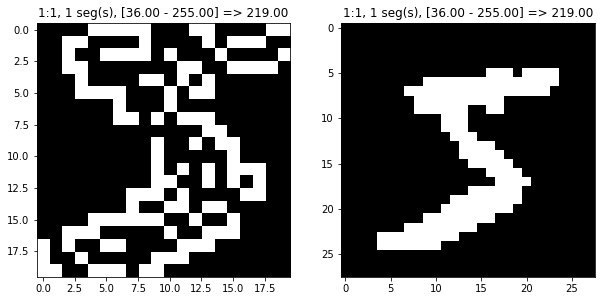

2


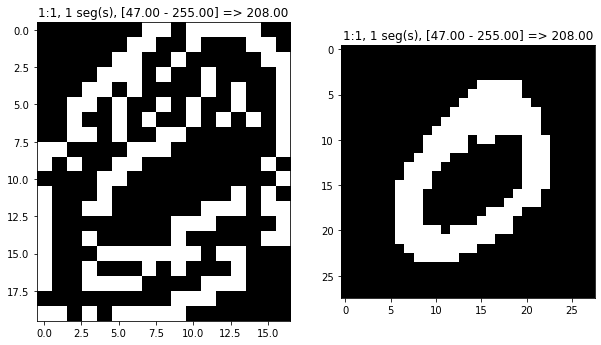

3


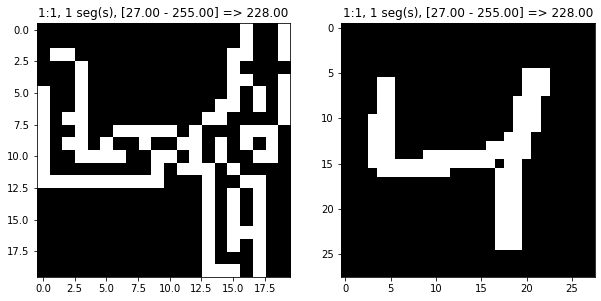

4


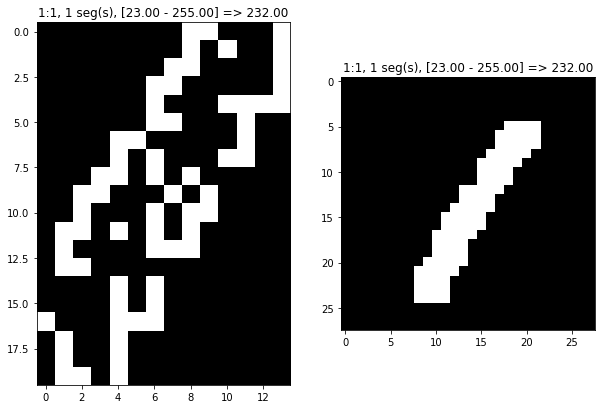

5


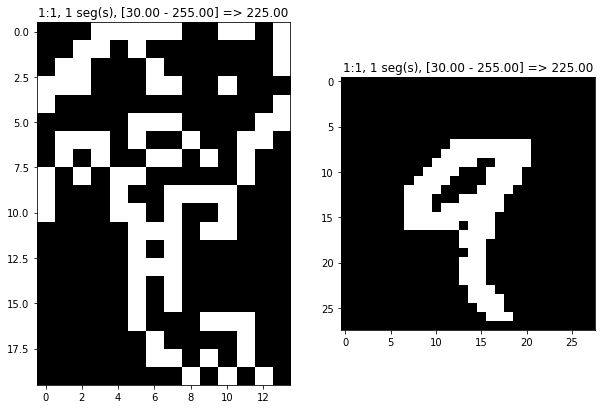

6


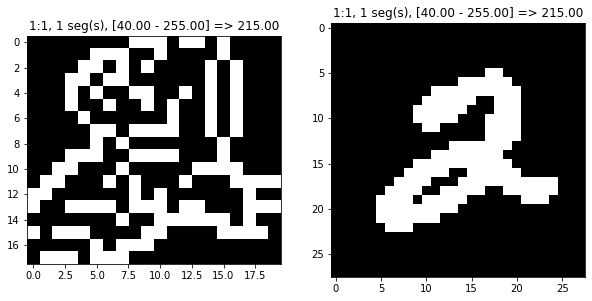

7


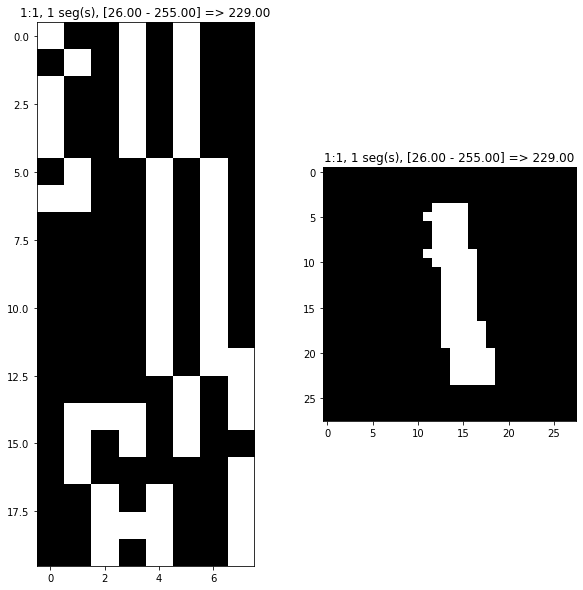

8


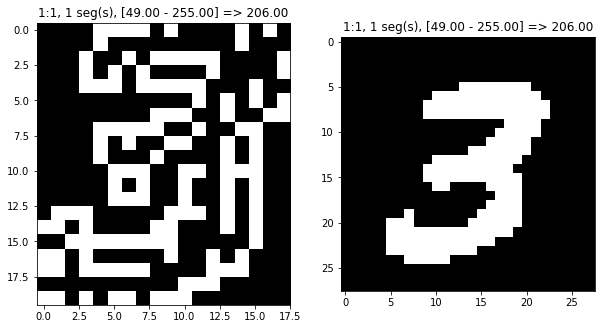

9


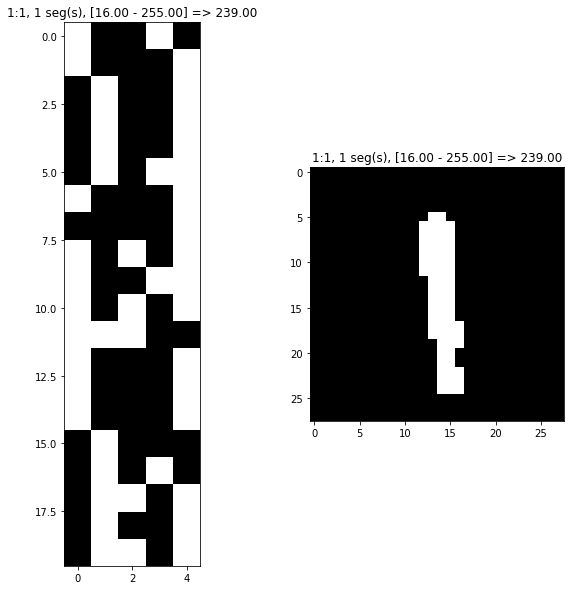

10


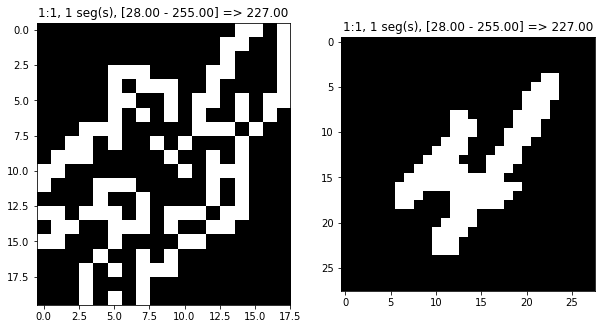

11


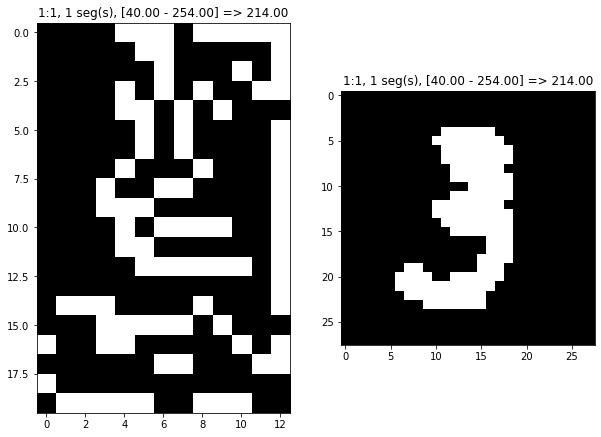

12


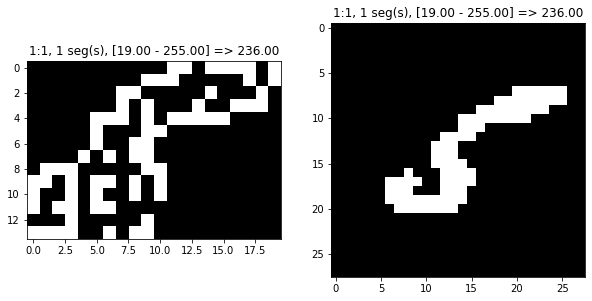

13


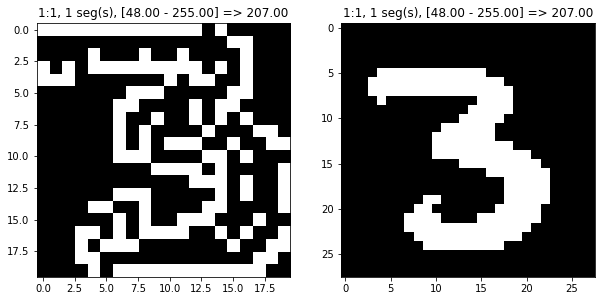

14


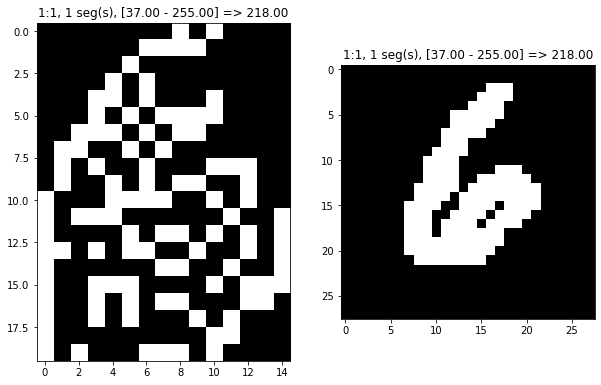

15


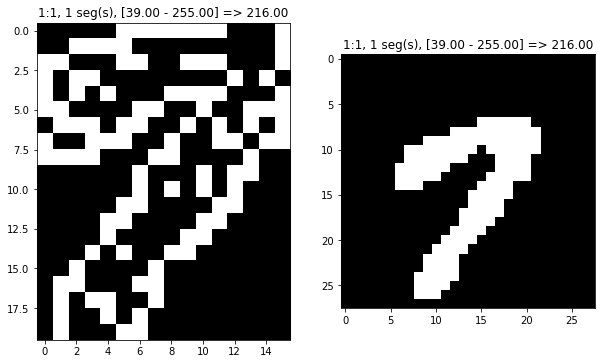

16


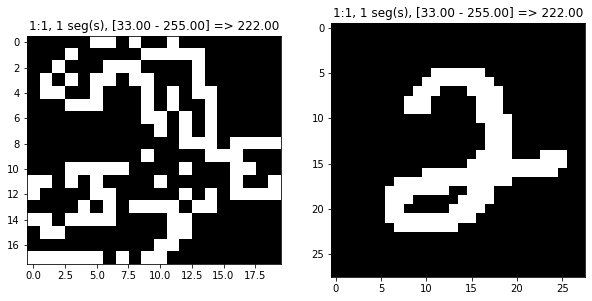

17


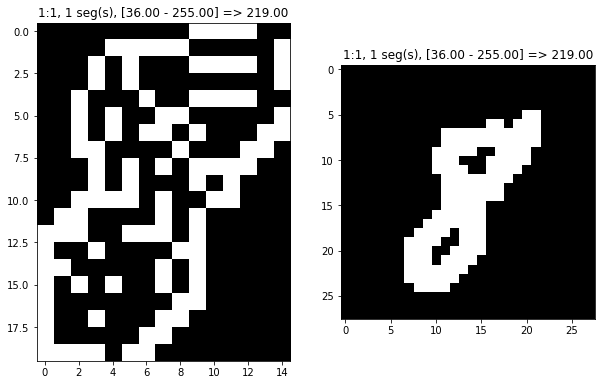

18


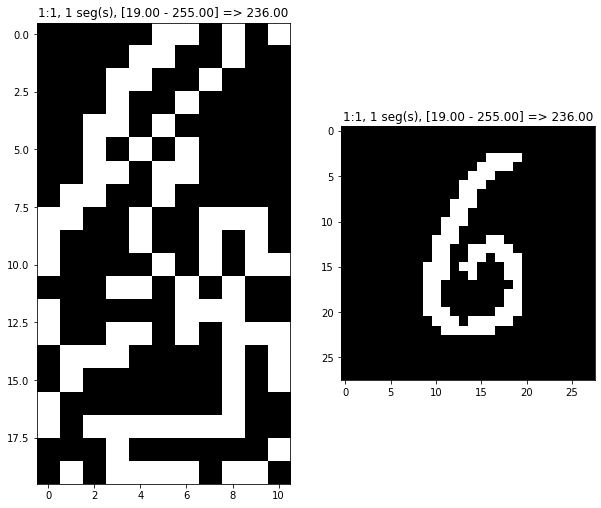

19


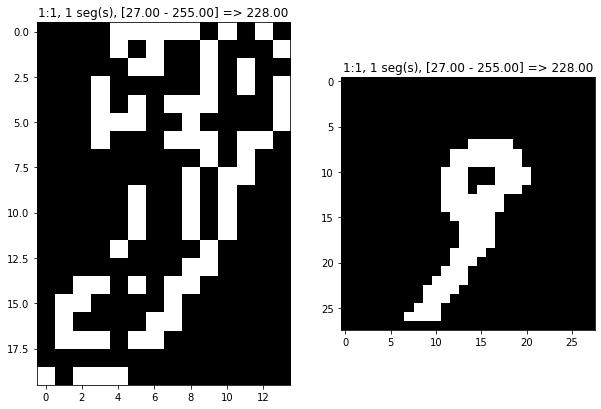

20


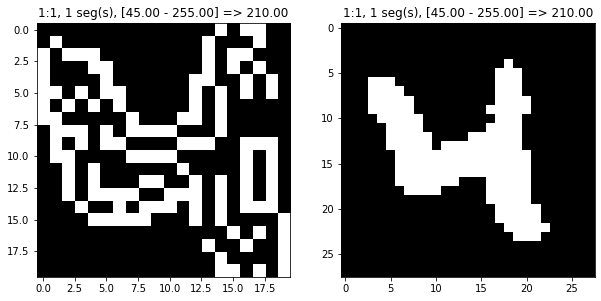

21


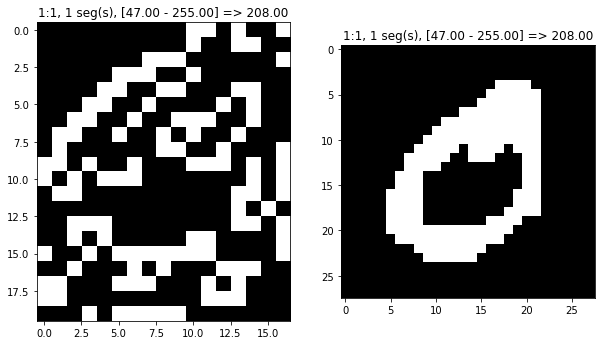

22


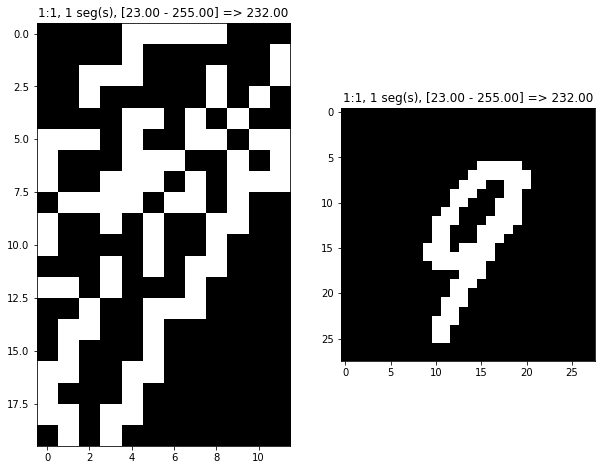

23


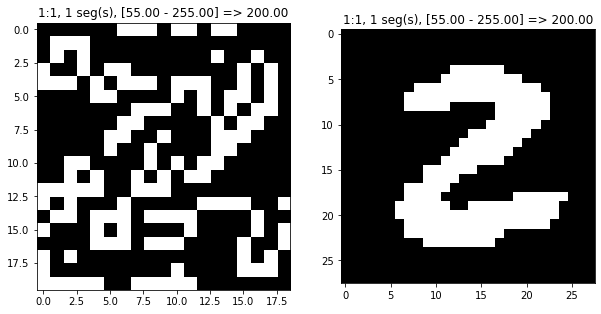

24


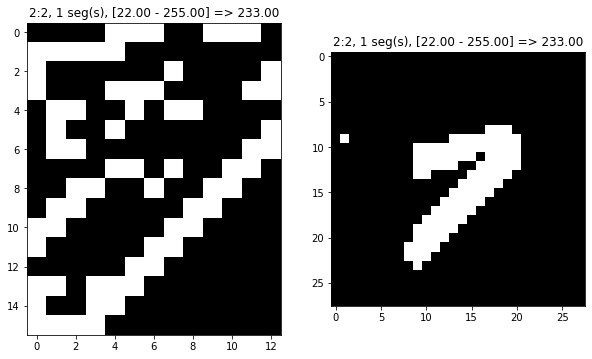

25


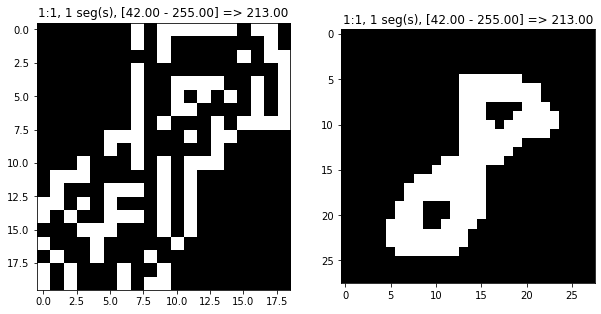

26


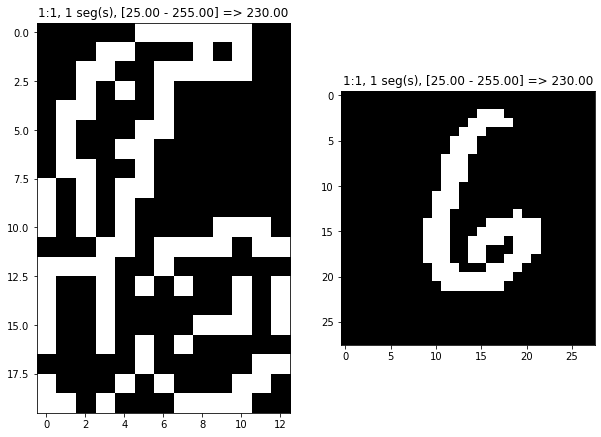

27


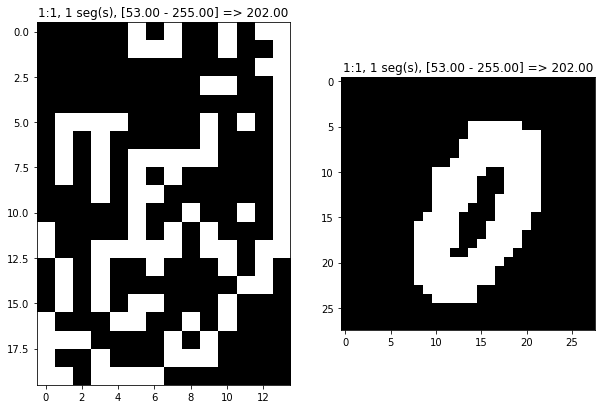

28


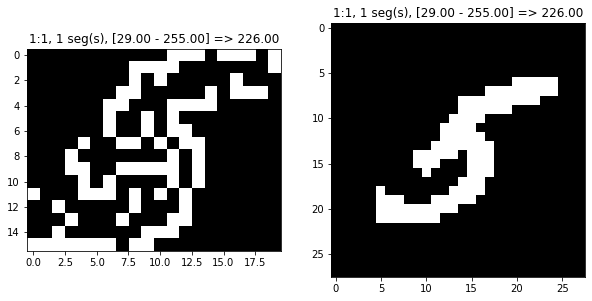

29


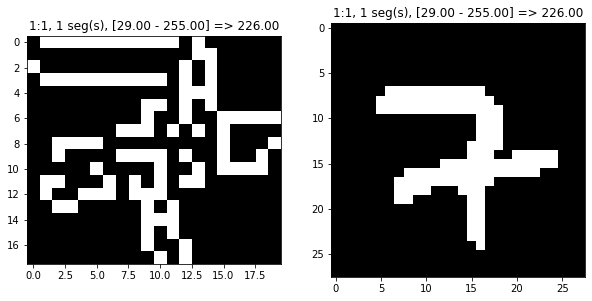

30


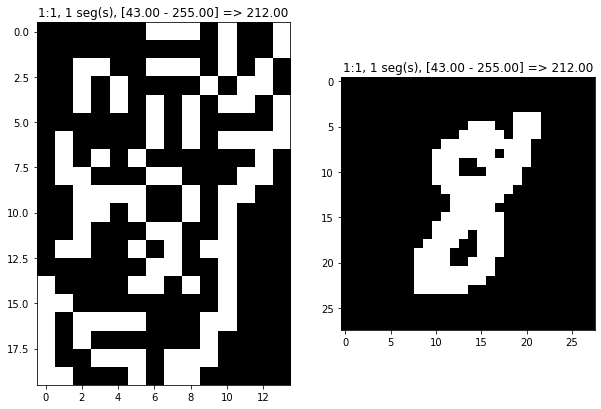

In [432]:
# get training data
images = simulateMNISTDigitRecognition(50)

collected = {x: 0 for x in range(10)}
cn = 3

counter = 0  # to hold all the data trained with

# for data in dataset
for (image_name, image, metadata) in images:
    if len(results['actual']) == cn*10:
        break

    # skip already satisfied criteria
    if collected[metadata] == cn:
        continue

    counter += 1
    collected[metadata] += 1
    
    print(counter)
    getSegments(image)

In [444]:
def compare(img_11, img_22):
    def centralize(img_coordinates):
        return np.array([row - row.mean() for row in img_coordinates], dtype=np.float64)

    # get the actual image embedded in negative space
    def getSubImage(img):
        pos = np.where(img != -1)
        ar1, ar2 = pos

        x1, x2 = min(ar1), max(ar1)+1
        y1, y2 = min(ar2), max(ar2)+1

        return img[x1:x2, y1:y2].copy()

    # get the sub image of images
    img_1 = getSubImage(img_11)
    img_2 = getSubImage(img_22)

    # get the shape of the images
    c11, c12 = img_1.shape
    c21, c22 = img_2.shape

    # get the min of the x and size
    r = c21 if c21 < c11 else c11
    c = c22 if c22 < c12 else c12
    
    # size ratio (quantifies reduction/loss of data)
    scale_error = ((r*c)**2) / ((c11 * c12) * (c21 * c22))
    
    img1_before_before = img_1.copy()
    img2_before_before = img_2.copy()

    # the place holder pixel, using 255 - x cos of background and foreground can blend
    r1 = 255 - img_1[img_1 != -1].mean()
    img_r1 = None if r1 in img_1 else r1

    r2 = 255 - img_2[img_2 != -1].mean()
    img_r2 = None if r2 in img_2 else r2
    
    # remove -1 cos of interpolation
    if img_r1 is not None:
        img_1[img_1 == -1] = img_r1

    if img_r2 is not None:
        img_2[img_2 == -1] = img_r2

    # resize images (scale it down to minimum)
    img_1 = cv2.resize(img_1.astype(np.uint8), (c, r), interpolation=cv2.INTER_AREA).astype(np.int64)
    img_2 = cv2.resize(img_2.astype(np.uint8), (c, r), interpolation=cv2.INTER_AREA).astype(np.int64)

    img1_before = img_1.copy()
    img2_before = img_2.copy()
    
    # put back -1 after interpolation
    if img_r1 is not None:
        img_1[img_1 == int(img_r1)] = 0
        img1_before[img1_before == int(img_r1)] = -1

    if img_r2 is not None:
        img_2[img_2 == int(img_r2)] = 255
        img2_before[img2_before == int(img_r2)] = -2
    
    initial_kernel_size = np.array([r, c])
    delta = initial_kernel_size.min() + 1
    
    similarities = []
    kernel_size = (initial_kernel_size/3).astype(np.int8)
    
    img1_kernels = np.array(getKernels(img_1, kernel_size))
    img2_kernels = np.array(getKernels(img_2, kernel_size))

    kernel_similarities = []
    kr, kc, *_ = img1_kernels.shape

    for i in range(kr):
        for j in range(kc):
            kernel_similarities.append(np.diag(np.round(cosine_similarity(img1_kernels[i, j], img2_kernels[i, j]), 4)).mean())

    similarities.append(np.array(kernel_similarities).mean())
        
    cos_similarity = np.array(similarities).mean()
    similarity = scale_error * cos_similarity
#     imgx = cv2.Canny(img_1.astype(np.uint8), 10, 256)
    
#     li = [None, img_1, img_2, imgx]
#     li = [None, img1_before_before, img2_before_before]
    li = [None, img1_before, img2_before]
    fig=plt.figure(figsize=(10, 10))
    cols = len(li)
    for k in range(1, cols):
        ax = fig.add_subplot(1, cols-1, k)
        ax.set_title(f'similarity {0:.4f}')

        plt.imshow(li[k], cmap='gray', vmin=0, vmax=255)
    plt.show()
    
    return f"sim = {similarity:.4f}, cos_sim = {cos_similarity:.4f} scale_error = {scale_error:.4f}"

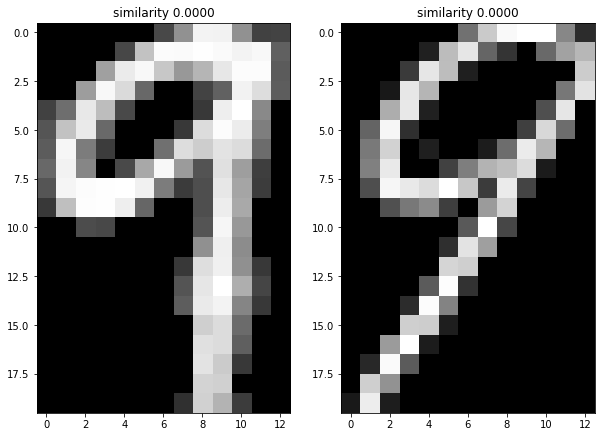

9 <==> 9 = sim = 0.6240, cos_sim = 0.7681 scale_error = 0.8125



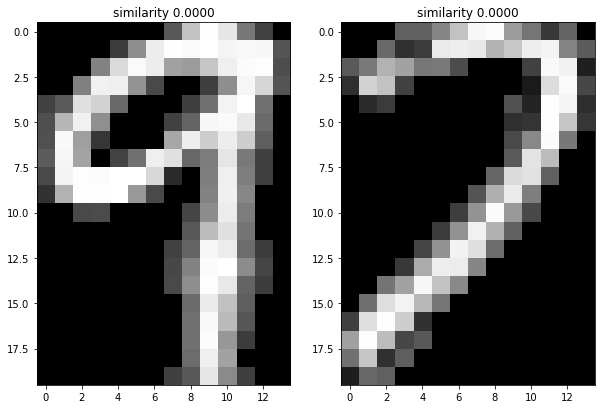

9 <==> 7 = sim = 0.6584, cos_sim = 0.7901 scale_error = 0.8333



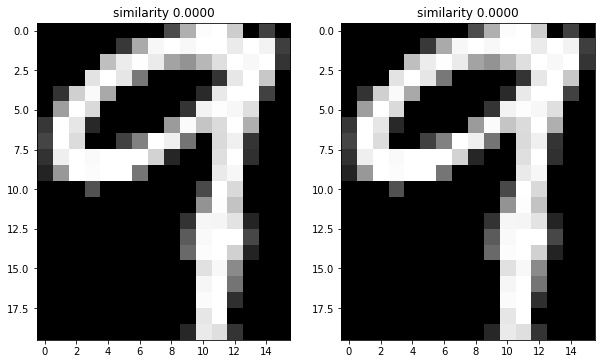

9 <==> 9 = sim = 0.7466, cos_sim = 0.7466 scale_error = 1.0000



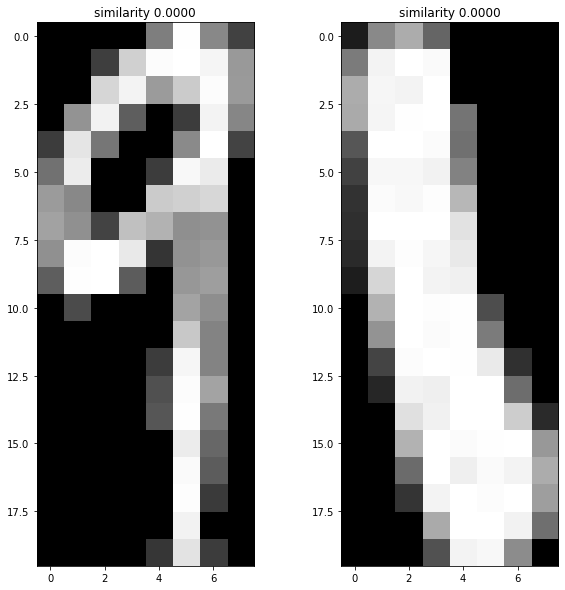

9 <==> 1 = sim = 0.4323, cos_sim = 0.8647 scale_error = 0.5000



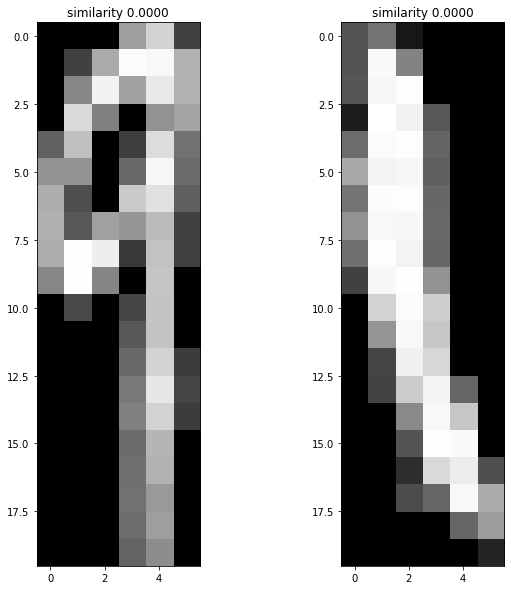

9 <==> 1 = sim = 0.3081, cos_sim = 0.8626 scale_error = 0.3571



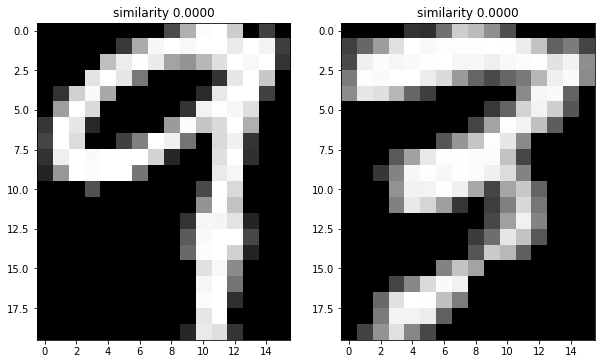

9 <==> 3 = sim = 0.6471, cos_sim = 0.7280 scale_error = 0.8889



In [445]:
j = 3
img_x = list(getSegments(image3))

for x in img_x:
    for i, imagex in enumerate([image1, image2, image3, image4, image5, image6]):
#         if i != j-1:
#             continue
        img_y = list(getSegments(imagex))
        for y in img_y:
            print(f"{nums[j-1]} <==> {nums[i]} = {compare(x, y)}")
        print()


In [ ]:
nums = [9, 7, 9, 1, 1, 3]

image1 = toGrey(load_image('dump/old_test/img_3.jpg'))
image2 = toGrey(load_image('dump/old_test/img_12.jpg'))
image3 = toGrey(load_image('dump/old_test/9.jpg'))
image4 = toGrey(load_image('dump/old_test/img_229.jpg'))
image5 = toGrey(load_image('dump/old_test/img_217.jpg'))
image6 = toGrey(load_image('dump/old_test/img_215.jpg'))
# image_plate = toGrey(load_image('dump/plate.png'))
image_test = toGrey(load_image('dump/WIN_20190829_16_17_54_Pro.jpg'))

In [ ]:
plt.imshow(image1.astype(np.uint8), cmap='gray', vmin=0)

In [ ]:
plt.imshow(image2.astype(np.uint8), cmap='gray', vmin=0)

In [17]:
plt.imshow(image3.astype(np.uint8), cmap='gray', vmin=0)

NameError: name 'image3' is not defined

In [ ]:
plt.imshow(image4.astype(np.uint8), cmap='gray', vmin=0)

In [18]:
plt.imshow(image5.astype(np.uint8), cmap='gray', vmin=0)

NameError: name 'image5' is not defined

In [19]:
plt.imshow(image6.astype(np.uint8), cmap='gray', vmin=0)

NameError: name 'image6' is not defined

In [ ]:
img_1x = getSegments(image1, 20)

In [20]:
img_2x = getSegments(image2, 34)

NameError: name 'image2' is not defined

In [21]:
img_3x = getSegments(image3, 49)

NameError: name 'image3' is not defined

In [22]:
img_4x = getSegments(image4)

NameError: name 'image4' is not defined

In [23]:
img_5x = getSegments(image5)

NameError: name 'image5' is not defined

In [24]:
img_6x = getSegments(image6, 42)

NameError: name 'image6' is not defined

In [ ]:
img_1x.shape, img_2x.shape, img_3x.shape, img_4x.shape, img_5x.shape, img_6x.shape

In [25]:
plt.imshow(img_1x, cmap='gray', vmin=0, vmax=255)

NameError: name 'img_1x' is not defined

In [ ]:
plt.imshow(img_2x, cmap='gray', vmin=0, vmax=255)

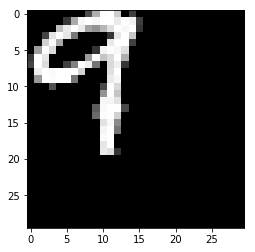

In [205]:
plt.imshow(img_3x, cmap='gray', vmin=0, vmax=255)

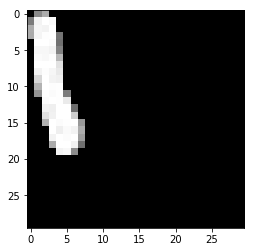

In [206]:
plt.imshow(img_4x, cmap='gray', vmin=0, vmax=255)

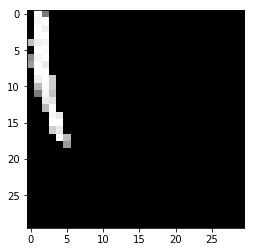

In [207]:
plt.imshow(img_5x, cmap='gray', vmin=0, vmax=255)

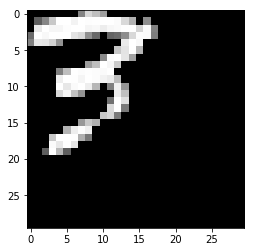

In [208]:
plt.imshow(img_6x, cmap='gray', vmin=0, vmax=255)

In [276]:
similarities = []
for img_1y in [img_1x, img_2x, img_3x, img_4x, img_5x, img_6x]:
    similarities.append(compare(img_1x, img_1y))

0.6261764705882353 1.0 0.6261764705882353 1.0 0.7507843137254903 0.7507843137254903
0.7610859728506788 0.9592185592185593 0.7604682898800547 0.9230769230769231 0.8269242739830975 0.7633147144459361
0.6993837535014006 0.9590616246498599 0.7005462184873951 0.75 0.7863305322128852 0.5897478991596639
0.37844084493700864 0.9427678317703894 0.42968646395756366 0.6666666666666666 0.5836317135549872 0.3890878090366581
0.40748366013071896 0.9095751633986928 0.49124183006535954 0.475 0.6027668845315904 0.2863142701525055
0.638582202111614 0.9482805429864254 0.6480693815987933 0.6666666666666666 0.7449773755656109 0.49665158371040724


In [277]:
for i, similarity in enumerate(similarities):
    print(f"{nums[0]} <==> {nums[i]} = {similarity}")

9 <==> 9 = 0.8753921568627452
9 <==> 7 = 0.8750005985300103
9 <==> 9 = 0.7681652661064426
9 <==> 1 = 0.6251491901108269
9 <==> 1 = 0.5388834422657952
9 <==> 3 = 0.7058220211161388


[[108 108 108 108 108 108 113 202 249 255 255 135  44]
 [108 108 108 108  33 188 230 101  52 108 106 162 183]
 [108 108 108  58 230 189  31 108 108 108 108 108 204]
 [108 108  24 231 181 108 108 108 108 108 108 119 228]
 [108 108 173 232  32 108 108 108 108 108  79 230 108]
 [108 100 246  47 108 108 108 108 108  63 216 109 108]
 [108 122 210 108  31 108 108  28 109 235 182 108 108]
 [108 128 233 108 108  66 126 180 191 220  27 108 108]
 [108  78 246 233 220 255 199  59 235  68 108 108 108]
 [108 108  80 120 139  62 108 155 211 108 108 108 108]
 [108 108 108 108 108 108  90 255  70 108 108 108 108]
 [108 108 108 108 108  47 227 159 108 108 108 108 108]
 [108 108 108 108 108 213 207 108 108 108 108 108 108]
 [108 108 108 108  91 253  50 108 108 108 108 108 108]
 [108 108 108  45 252 131 108 108 108 108 108 108 108]
 [108 108 108 207 205  30 108 108 108 108 108 108 108]
 [108 108 155 255  28 108 108 108 108 108 108 108 108]
 [108  40 250  91 108 108 108 108 108 108 108 108 108]
 [108 207 